In [21]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import tensorflow as tf
import os 
import xml.etree.ElementTree as ET 
from collections import Counter 
import cv2 
import matplotlib.patches as patches
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [3]:
# Tentukan path dataset
dataset_path = './data_rebalanced'

# Fungsi untuk mengeksplorasi struktur folder
def explore_dataset_structure(base_path):
    structure = {}
    for split in ['train', 'test', 'valid']:
        split_path = os.path.join(base_path, split)
        if os.path.exists(split_path):
            files = os.listdir(split_path)
            images = [f for f in files if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
            xmls = [f for f in files if f.lower().endswith('.xml')]
            
            structure[split] = {
                'total_files': len(files),
                'images': len(images),
                'xml_files': len(xmls),
                'sample_files': files[:5] # 5 file pertama sebagai contoh
            }
            
    return structure

In [4]:
# Jalankan eksplorasi struktur dataset
dataset_structure = explore_dataset_structure(dataset_path)

print("=== Struktur Dataset ===")
for split, info in dataset_structure.items():
    print(f"\n{split.upper()}:")
    print(f" Total files: {info['total_files']}")
    print(f" Images: {info['images']}")
    print(f" XML files: {info['xml_files']}")
    print(f" Sample files: {info['sample_files']}")

=== Struktur Dataset ===

TRAIN:
 Total files: 13172
 Images: 6586
 XML files: 6586
 Sample files: ['00a20f6f-e8bd-4453-9e25-36ea70feb626___RS_GLSp-4655_270deg_JPG.rf.32757325fe3ef8aea732033c88765eca.jpg', '00a20f6f-e8bd-4453-9e25-36ea70feb626___RS_GLSp-4655_270deg_JPG.rf.32757325fe3ef8aea732033c88765eca.xml', '00a20f6f-e8bd-4453-9e25-36ea70feb626___RS_GLSp-4655_90deg_JPG.rf.35086f4585273d16e45a4b5270e9f2c2.jpg', '00a20f6f-e8bd-4453-9e25-36ea70feb626___RS_GLSp-4655_90deg_JPG.rf.35086f4585273d16e45a4b5270e9f2c2.xml', '00a20f6f-e8bd-4453-9e25-36ea70feb626___RS_GLSp-4655_90deg_JPG.rf.4595f7705c80bfd6c0a0237c776344bd.jpg']

TEST:
 Total files: 1888
 Images: 944
 XML files: 944
 Sample files: ['00a20f6f-e8bd-4453-9e25-36ea70feb626___RS_GLSp-4655_270deg_JPG.rf.cdbe010b4db9970466a604554eca585e.jpg', '00a20f6f-e8bd-4453-9e25-36ea70feb626___RS_GLSp-4655_270deg_JPG.rf.cdbe010b4db9970466a604554eca585e.xml', '00a20f6f-e8bd-4453-9e25-36ea70feb626___RS_GLSp-4655_JPG.rf.ef4cbeddd1ce55024ef59df4c47959

In [5]:
# Analisis file XML (anotasi)
def parse_xml_annotations(xml_path):
    """Parse XML annotation file"""
    tree = ET.parse(xml_path)
    root = tree.getroot()
    
    annotation_info = {
        'filename': root.find('filename').text if root.find('filename') is not None else '',
        'width': int(root.find('size/width').text) if root.find('size/width') is not None else 0,
        'height': int(root.find('size/height').text) if root.find('size/height') is not None else 0,
        'objects': []
    }
    
    
    for obj in root.findall('object'):
        obj_info = {
            'name': obj.find('name').text if obj.find('name') is not None else '',
            'bbox': {
                'xmin': int(obj.find('bndbox/xmin').text) if obj.find('bndbox/xmin') is not None else 0,
                'ymin': int(obj.find('bndbox/ymin').text) if obj.find('bndbox/ymin') is not None else 0,
                'xmax': int(obj.find('bndbox/xmax').text) if obj.find('bndbox/xmax') is not None else 0,
                'ymax': int(obj.find('bndbox/ymax').text) if obj.find('bndbox/ymax') is not None else 0,
            }
        }
        annotation_info['objects'].append(obj_info)
        
    return annotation_info



def analyze_annotations(base_path):
    """Analisis semua file XML dalam dataset"""
    all_annotations = {}
    class_counts = Counter()
    image_sizes = []
    bbox_sizes = []
    
    for split in ['train', 'test', 'valid']:
        split_path = os.path.join(base_path, split)
        if not os.path.exists(split_path):
            continue 
        
        xml_files = [f for f in os.listdir(split_path) if f.endswith('.xml')]
        split_annotations = []
        
        for xml_file in xml_files:
            xml_path = os.path.join(split_path, xml_file)
            try: 
                annotation = parse_xml_annotations(xml_path)
                split_annotations.append(annotation)
                
                # Collect statistics
                image_sizes.append((annotation['width'], annotation['height']))
                
                for obj in annotation['objects']:
                    class_counts[obj['name']] += 1
                    bbox = obj['bbox']
                    bbox_width = bbox['xmax'] - bbox['xmin']
                    bbox_height = bbox['ymax'] - bbox['ymin']
                    bbox_sizes.append((bbox_width, bbox_height))
                    
            except Exception as e:
                print(f"Error parsing {xml_file}: {e}")
            
        all_annotations[split] = split_annotations
    return all_annotations, class_counts, image_sizes, bbox_sizes



In [6]:
annotations, class_counts, image_sizes, bbox_sizes = analyze_annotations(dataset_path)

print("=== Analisis Anotasi ===")
print(f"Total kelas penyakit: {len(class_counts)}")
print(f"Kelas-kelas yang ditemukan: {list(class_counts.keys())}")
print("\nDistribusi kelas:")
for class_name, count in class_counts.items():
    print(f" {class_name}: {count}")

=== Analisis Anotasi ===
Total kelas penyakit: 3
Kelas-kelas yang ditemukan: ['Grey Leaf Spot', 'Corn Rust', 'Leaf Blight']

Distribusi kelas:
 Grey Leaf Spot: 3015
 Corn Rust: 3060
 Leaf Blight: 3416


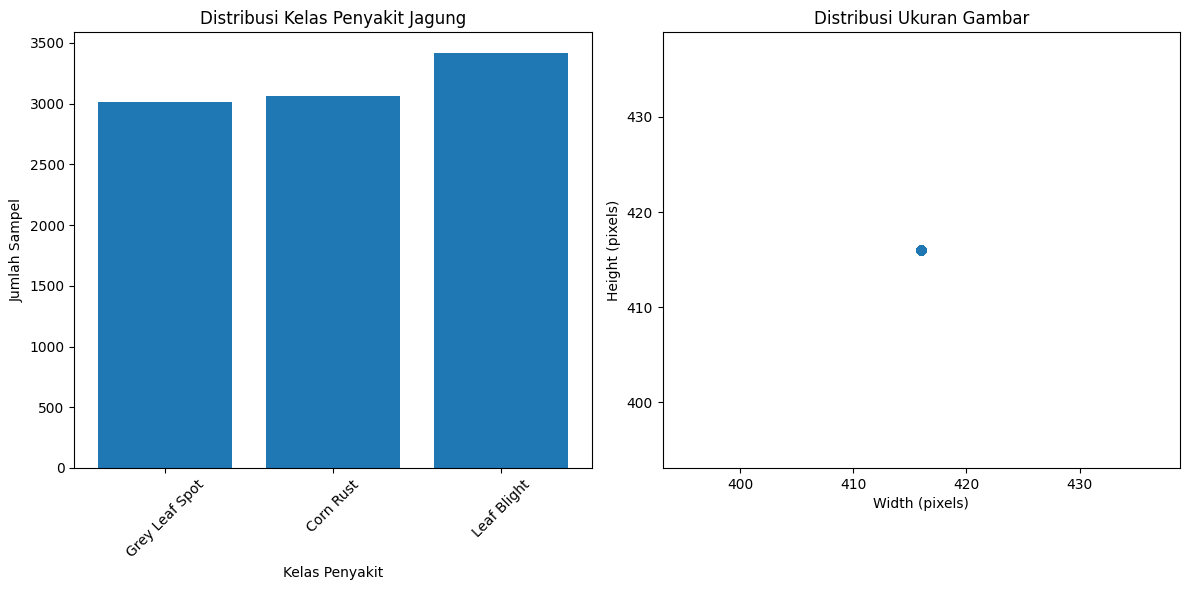

In [7]:
# Visualisasi distribusi kelas
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
classes = list(class_counts.keys())
counts = list(class_counts.values())
plt.bar(classes, counts)
plt.title('Distribusi Kelas Penyakit Jagung')
plt.xlabel('Kelas Penyakit')
plt.ylabel('Jumlah Sampel')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
widths = [size[0] for size in image_sizes]
heights = [size[1] for size in image_sizes]
plt.scatter(widths, heights, alpha=.6)
plt.title('Distribusi Ukuran Gambar')
plt.xlabel('Width (pixels)')
plt.ylabel('Height (pixels)')

plt.tight_layout()
plt.show()

In [8]:
print("\n=== STATISTIK UKURAN GAMBAR ===")
print(f"Ukuran gambar unik: {len(set(image_sizes))}")
print(f"Ukuran paling umum: {Counter(image_sizes).most_common(3)}")
print(f"Width rata-rata: {np.mean(widths):.1f} ± {np.std(widths):.1f}")
print(f"Height rata-rata: {np.mean(heights):.1f} ± {np.std(heights):.1f}")


=== STATISTIK UKURAN GAMBAR ===
Ukuran gambar unik: 1
Ukuran paling umum: [((416, 416), 9411)]
Width rata-rata: 416.0 ± 0.0
Height rata-rata: 416.0 ± 0.0


In [9]:
# Analisis distribusi per spit (train/test/valid)
split_stats = {}
for split, split_annotation in annotations.items():
    split_classes = Counter()
    for annotation in split_annotation:
        for obj in annotation['objects']:
            split_classes[obj['name']] += 1
    split_stats[split] = split_classes
    
df_splits = pd.DataFrame(split_stats).fillna(0)
print("Distribusi per split")
print(df_splits)

Distribusi per split
                train  test  valid
Grey Leaf Spot   2110   302    603
Corn Rust        2141   307    612
Leaf Blight      2390   343    683


<Figure size 1200x800 with 0 Axes>

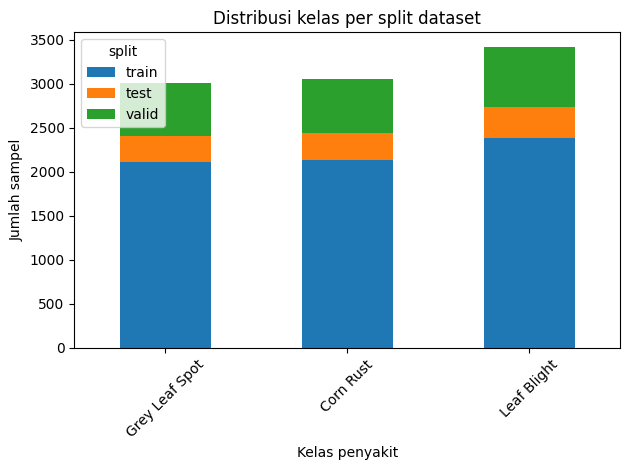

In [10]:
plt.figure(figsize=(12, 8))
df_splits.plot(kind='bar', stacked=True)
plt.title('Distribusi kelas per split dataset')
plt.xlabel('Kelas penyakit')
plt.ylabel('Jumlah sampel')
plt.legend(title='split')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [11]:


def visualize_sample_with_annotation(base_path, split='train', num_samples=3):
    """Visualisasi contoh gambar dengan bounding box"""
    split_path = os.path.join(base_path, split)
    xml_files = [f for f in os.listdir(split_path) if f.endswith('.xml')][:num_samples]
    
    fig, axes = plt.subplots(1, len(xml_files), figsize=(15, 5))
    if len(xml_files) == 1:
        axes = [axes]
        
    for idx, xml_file in enumerate(xml_files):
        # parse annotation
        xml_path = os.path.join(split_path, xml_file)
        annotation = parse_xml_annotations(xml_path)
        
        # laod image
        image_name = annotation['filename']
        image_path = os.path.join(split_path, image_name)
        
        if os.path.exists(image_path):
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            axes[idx].imshow(image)
            # axes[idx].set_title(f"{image_name}")
            axes[idx].axis('off')
            
            # Draw bounding boxes
            for obj in annotation['objects']:
                bbox = obj['bbox']
                rect = patches.Rectangle(
                    (bbox['xmin'], bbox['ymin']),
                    bbox['xmax'] - bbox['xmin'],
                    bbox['ymax'] - bbox['ymin'],
                    linewidth=2, edgecolor='red', facecolor='none'
                )
                axes[idx].add_patch(rect)
                axes[idx].text(bbox['xmin'], bbox['ymin']-10, obj['name'],
                               color='red', fontsize=10, weight='bold')
    
    plt.tight_layout()
    plt.show()
    
    

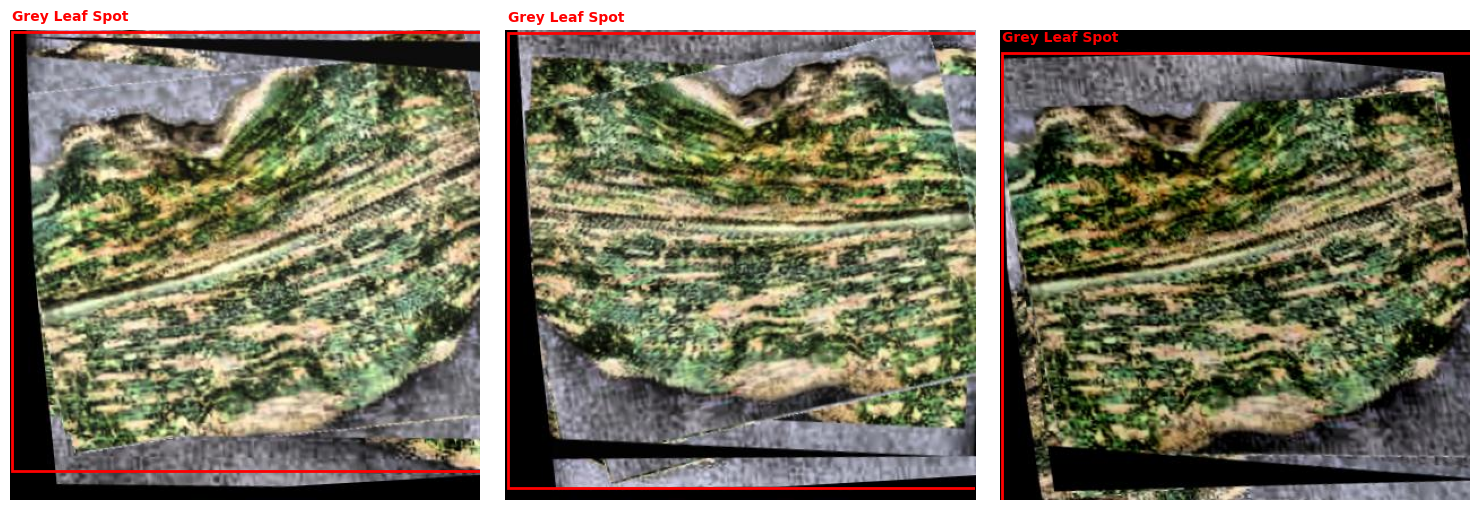

In [12]:
# Tampilkan contoh
visualize_sample_with_annotation(dataset_path, 'train', 3)

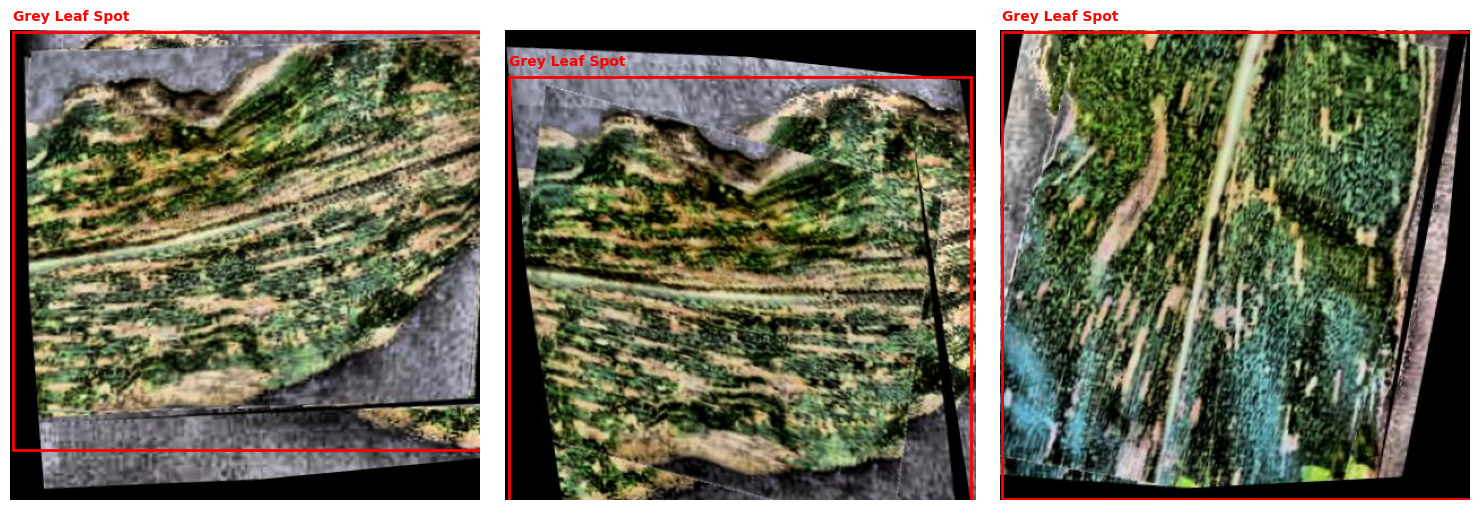

In [13]:
visualize_sample_with_annotation(dataset_path, 'test', 3)

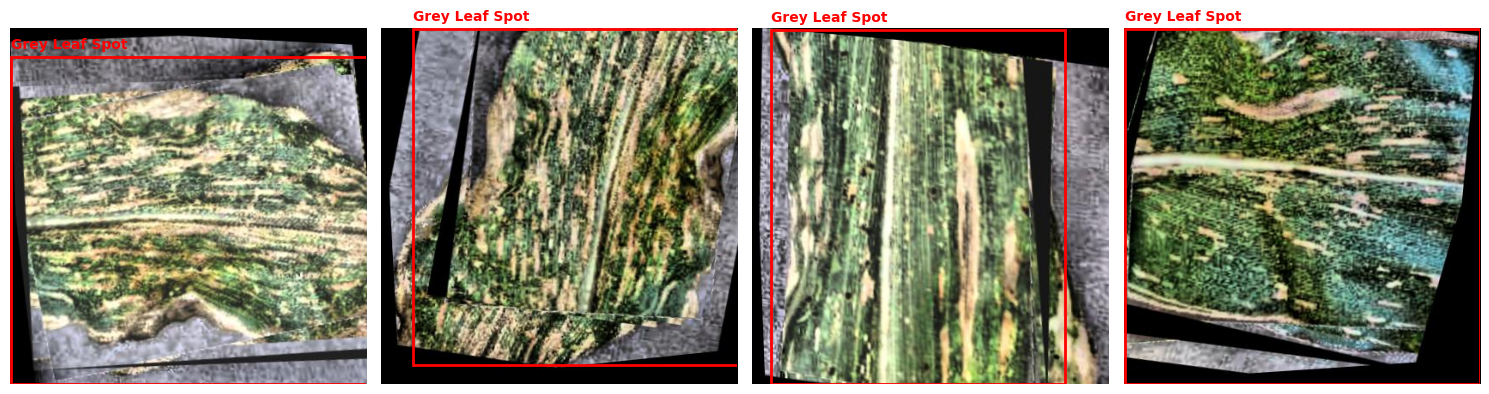

In [14]:
visualize_sample_with_annotation(dataset_path, 'valid', 4)

## Re-splitting Dataset

If your dataset is unbalanced for the distribution you have to uncomment this code and then run the code to fixed the unbalanced dataset.

In [ ]:
# def reorganize_dataset(source_path, target_path, train_ratio=0.7, valid_ratio=0.2, test_ratio=0.1):
#     """
#     Reorganisasi dataset dengan split yang lebih seimbang
#     """
#     # Pastikan rasio total = 1.0
#     assert abs(train_ratio + valid_ratio + test_ratio - 1.0) < 1e-6, "Rasio harus berjumlah 1.0"
    
#     # Buat folder target jika belum ada
#     os.makedirs(target_path, exist_ok=True)
#     for split in ['train', 'test', 'valid']:
#         os.makedirs(os.path.join(target_path, split), exist_ok=True)
        
#     # Kumpulkan semua file dari semua split
#     all_files = defaultdict(list) # {class_name: [list of (img_file, xml_file)]}
    
#     # Scan semua folder (train, valid, test) yang ada
#     for split in ['train', 'test', 'valid']:
#         split_path = os.path.join(source_path, split)
#         if not os.path.exists(split_path):
#             continue 
        
#         xml_files = [f for f in os.listdir(split_path) if f.endswith('.xml')]
        
#         for xml_file in xml_files:
#             xml_path = os.path.join(split_path, xml_file)
            
#             # Parse XML untuk mendapatkan class
#             try:
#                 annotation = parse_xml_annotations(xml_path)
#                 img_file = annotation['filename']
#                 img_path = os.path.join(split_path, img_file)
                
#                 # Ambil kelas dari objek pertama (asumsi satu kelas per gambar)
#                 if annotation['objects']:
#                     class_name = annotation['objects'][0]['name']
                    
#                     # Pastikan file gambar ada
#                     if os.path.exists(img_path):
#                         all_files[class_name].append((img_path, xml_path))
                        
#             except Exception as e: 
#                 print(f"Error processing {xml_file}: {e}")
    
#     # Tampilkan statistik sebulum split
#     print("=== Statistik Sebelum Re-Split ===")
#     total_samples = 0
#     for class_name, files in all_files.items():
#         print(f"{class_name}: {len(files)} samples")
#         total_samples += len(files)
#     print(f"Total: {total_samples} sampel")
    
#     # Lakukan stratified split untuk setiap kelas
#     split_results = {'train': [], 'valid': [], 'test': []}
    
#     for class_name, files in all_files.items():
#         # shuffle files
#         random.shuffle(files)
        
#         # Hitung jumlah sampel untuk setiap split
#         n_total = len(files)
#         n_train = int(n_total * train_ratio)
#         n_valid = int(n_total * valid_ratio)
#         n_test = n_total - n_train - n_valid # sisa untuk test
        
#         # Split files
#         train_files = files[:n_train]
#         valid_files = files[n_train:n_train + n_valid]
#         test_files = files[n_train + n_valid:]
        
#         split_results['train'].extend(train_files)
#         split_results['valid'].extend(valid_files)
#         split_results['test'].extend(test_files)
        
#         print(f"\n{class_name}:")
#         print(f"Train: {len(train_files)}")
#         print(f"Valid: {len(valid_files)}")
#         print(f"Test: {len(test_files)}")
        
#     print("\n=== Copying Files ===")
#     for split, files in split_results.items():
#         split_dir = os.path.join(target_path, split)
        
#         for img_path, xml_path in files:
#             # Copy image file
#             img_filename = os.path.basename(img_path)
#             shutil.copy2(img_path, os.path.join(split_dir, img_filename))
            
#             # Copy xml file
#             xml_filename = os.path.basename(xml_path)
#             shutil.copy2(xml_path, os.path.join(split_dir, xml_filename))
        
#         print(f"{split}: {len(files)} files copied")

#     return split_results


In [19]:
# random.seed(42)

# source_dataset_path = './data'
target_dataset_path = './data_rebalanced'

# split_results = reorganize_dataset(
#     source_dataset_path,
#     target_dataset_path,
#     train_ratio=0.7,
#     test_ratio=0.1,
#     valid_ratio=0.2
# )

In [20]:
# # Verifikasi hasil dengan menjalankan EDA pada dataset baru
# print("\n" + "="*50)
# print("Verifikasi Dataset Baru")
# print("="*50)

# new_dataset_structure = explore_dataset_structure(target_dataset_path)
# new_annotations, new_class_counts, _, _ = analyze_annotations(target_dataset_path)


# # Analisis distribusi per split yang baru
# new_split_stats = {}
# for split, split_annotations in new_annotations.items():
#     split_classes = Counter()
#     for annotation in split_annotations:
#         for obj in annotation['objects']:
#             split_classes[obj['name']] += 1
#     new_split_stats[split] = split_classes
    
# # Buat DataFrame untuk perbandingan
# df_new_splits = pd.DataFrame(new_split_stats).fillna(0)
# print("\n=== Distribusi Baru Per Split ===")
# print(df_new_splits)


# Object Detection 

In [15]:
tf.random.set_seed(42)
np.random.seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.10.1
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Pendekatan Classification-Based Detection

In [16]:
# Reset dan buat model yang lebih sederhana

print("🔄 Switching to simpler approach...")

# 1. Buat dataset untuk classification
def create_classification_dataset(base_path):
    """
    Buat dataset classification dari bounding box annotations
    """
    images = []
    labels = []
    class_names = ['Grey Leaf Spot', 'Corn Rust', 'Leaf Blight']
    class_to_idx = {name: idx for idx, name in enumerate(class_names)}
    
    for split in ['train', 'valid', 'test']:
        split_path = os.path.join(base_path, split)
        if not os.path.exists(split_path):
            continue
            
        xml_files = [f for f in os.listdir(split_path) if f.endswith('.xml')]
        
        for xml_file in xml_files:
            xml_path = os.path.join(split_path, xml_file)
            
            try:
                # Parse XML
                tree = ET.parse(xml_path)
                root = tree.getroot()
                
                filename = root.find('filename').text
                img_path = os.path.join(split_path, filename)
                
                if not os.path.exists(img_path):
                    continue
                
                # Load image
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                
                # Extract crops from bounding boxes
                for obj in root.findall('object'):
                    class_name = obj.find('name').text
                    if class_name in class_to_idx:
                        bbox = obj.find('bndbox')
                        xmin = int(bbox.find('xmin').text)
                        ymin = int(bbox.find('ymin').text)
                        xmax = int(bbox.find('xmax').text)
                        ymax = int(bbox.find('ymax').text)
                        
                        # Crop image
                        crop = image[ymin:ymax, xmin:xmax]
                        if crop.size > 0:
                            # Resize crop
                            crop = cv2.resize(crop, (224, 224))
                            crop = crop.astype(np.float32) / 255.0
                            
                            images.append(crop)
                            labels.append(class_to_idx[class_name])
                            
            except Exception as e:
                print(f"Error processing {xml_file}: {e}")
                continue
    
    return np.array(images), np.array(labels), class_names

print("📊 Creating classification dataset...")
X, y, class_names = create_classification_dataset('./data_rebalanced')

print("Dataset created:")
print(f"- Total samples: {len(X)}")
print(f"- Image shape: {X[0].shape}")
print(f"- Classes: {class_names}")
print(f"- Class distribution: {np.bincount(y)}")

🔄 Switching to simpler approach...
📊 Creating classification dataset...
Dataset created:
- Total samples: 9491
- Image shape: (224, 224, 3)
- Classes: ['Grey Leaf Spot', 'Corn Rust', 'Leaf Blight']
- Class distribution: [3015 3060 3416]


In [17]:
def create_custom_corn_cnn(num_classes=3, input_shape=(224, 224, 3)):
    """
    Custom CNN architecture untuk klasifikasi penyakit jagung
    """
    model = models.Sequential([
        # Input layer
        layers.Input(shape=input_shape),
        
        # Block 1: Feature extraction untuk texture patterns
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Block 2: Deeper feature extraction
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Block 3: Complex pattern recognition
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Block 4: High-level features
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Block 5: Final feature extraction
        layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.GlobalAveragePooling2D(),
        
        # Classification head
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model

# Create custom model
print("🏗️ Creating custom CNN model...")
custom_model = create_custom_corn_cnn(num_classes=len(class_names))

# Compile dengan optimizer yang lebih aggressive
custom_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

custom_model.summary()

🏗️ Creating custom CNN model...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 32)      9248      
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 112, 112, 32)      0         
                                                                 
 conv2d_2 (Conv2D)      

In [18]:

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print("Data split:")
print(f"- Train: {len(X_train)} samples")
print(f"- Validation: {len(X_val)} samples") 
print(f"- Test: {len(X_test)} samples")



def create_advanced_augmentation():
    """
    Advanced augmentation khusus untuk disease detection
    """
    return ImageDataGenerator(
        # Geometric transformations
        rotation_range=30,
        width_shift_range=0.3,
        height_shift_range=0.3,
        shear_range=0.2,
        zoom_range=0.3,
        horizontal_flip=True,
        vertical_flip=True,
        
        # Color augmentations (penting untuk disease detection)
        brightness_range=[0.7, 1.3],
        channel_shift_range=0.2,
        
        # Fill mode
        fill_mode='reflect',
        
        # Preprocessing
        rescale=1./255,
        preprocessing_function=None
    )

# Create enhanced generators
print("📊 Creating enhanced data generators...")
train_datagen_advanced = create_advanced_augmentation()
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Note: Kita perlu re-scale data karena sebelumnya sudah di-normalize
X_train_raw = (X_train * 255).astype(np.uint8)
X_val_raw = (X_val * 255).astype(np.uint8)
X_test_raw = (X_test * 255).astype(np.uint8)

train_generator_advanced = train_datagen_advanced.flow(
    X_train_raw, y_train,
    batch_size=32,
    shuffle=True
)

val_generator_advanced = val_datagen.flow(
    X_val_raw, y_val,
    batch_size=32,
    shuffle=False
)

test_generator_advanced = test_datagen.flow(
    X_test_raw, y_test,
    batch_size=32,
    shuffle=False
)

Data split:
- Train: 6643 samples
- Validation: 1424 samples
- Test: 1424 samples
📊 Creating enhanced data generators...


In [19]:
# Enhanced callbacks
callbacks_custom = [
    # Simple weight saving (avoid serialization issues)
    ModelCheckpoint(
        './models/custom_corn_cnn_weights.h5',
        monitor='val_accuracy',
        save_best_only=True,
        save_weights_only=True,
        verbose=1
    ),
    
    # Early stopping dengan patience lebih besar
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    
    # Reduce LR on plateau sebagai backup
    ReduceLROnPlateau(
        monitor='val_accuracy',
        factor=0.2,
        patience=5,
        min_lr=1e-7,
        verbose=1
    )
]

print("✅ Custom callbacks configured!")

✅ Custom callbacks configured!


In [20]:
# Training dengan monitoring yang lebih detail
print("🚀 Starting custom CNN training...")

# Create models directory
os.makedirs('./models', exist_ok=True)

# Training
history_custom = custom_model.fit(
    train_generator_advanced,
    steps_per_epoch=len(X_train) // 32,
    epochs=50,
    validation_data=val_generator_advanced,
    validation_steps=len(X_val) // 32,
    callbacks=callbacks_custom,
    verbose=1
)

print("✅ Custom CNN training completed!")

🚀 Starting custom CNN training...
Epoch 1/50
207/207 [==============================] - ETA: 0s - loss: 1.1461 - accuracy: 0.5226
Epoch 1: val_accuracy improved from -inf to 0.32244, saving model to ./models\custom_corn_cnn_weights.h5
207/207 [==============================] - 108s 441ms/step - loss: 1.1461 - accuracy: 0.5226 - val_loss: 6.3506 - val_accuracy: 0.3224 - lr: 0.0010
Epoch 2/50
207/207 [==============================] - ETA: 0s - loss: 0.6393 - accuracy: 0.7489
Epoch 2: val_accuracy improved from 0.32244 to 0.62500, saving model to ./models\custom_corn_cnn_weights.h5
207/207 [==============================] - 98s 471ms/step - loss: 0.6393 - accuracy: 0.7489 - val_loss: 1.3121 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 3/50
207/207 [==============================] - ETA: 0s - loss: 0.4799 - accuracy: 0.8183
Epoch 3: val_accuracy improved from 0.62500 to 0.79474, saving model to ./models\custom_corn_cnn_weights.h5
207/207 [==============================] - 92s 446ms/step - lo

In [22]:
def calculate_detailed_metrics(model, test_generator, y_true):
    """Calculate detailed metrics manually"""
    
    # Predictions
    y_pred_proba = model.predict(test_generator, verbose=0)
    y_pred = np.argmax(y_pred_proba, axis=1)
    
    # Calculate metrics
    accuracy = np.mean(y_pred==y_true)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    
    print("📊 Detailed Metrics:")
    print(f" Accuracy: {accuracy:.4f}")
    print(f" Precision: {precision:.4f}")
    print(f" Recall: {recall:.4f}")
    print(f" F1-Score: {f1:.4f}")
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    }

In [24]:
print("Evaluate custom CNN...")

# Evaluation
test_results = custom_model.evaluate(test_generator_advanced, verbose=1)
print("\nCustom CNN Test Results:")
print(f"- Loss: {test_results[0]:.4f}")
print(f"- Accuracy: {test_results[1]:.4f}")
# print(f"- Precision: {test_results[2]:.4f}")
# print(f"- Recall: {test_results[3]:.4f}")

# Detailed predictions
y_pred_custom = custom_model.predict(test_generator_advanced, verbose=1)
y_pred_classes_custom = np.argmax(y_pred_custom, axis=1)

# Classification report
print("\n Detailed Classification Report:")
print(classification_report(y_test, y_pred_classes_custom, target_names=class_names))

Evaluate custom CNN...
45/45 [==============================] - 2s 42ms/step - loss: 0.0450 - accuracy: 0.9860

Custom CNN Test Results:
- Loss: 0.0450
- Accuracy: 0.9860
45/45 [==============================] - 2s 39ms/step

 Detailed Classification Report:
                precision    recall  f1-score   support

Grey Leaf Spot       0.98      0.99      0.98       453
     Corn Rust       1.00      0.99      1.00       459
   Leaf Blight       0.98      0.98      0.98       512

      accuracy                           0.99      1424
     macro avg       0.99      0.99      0.99      1424
  weighted avg       0.99      0.99      0.99      1424



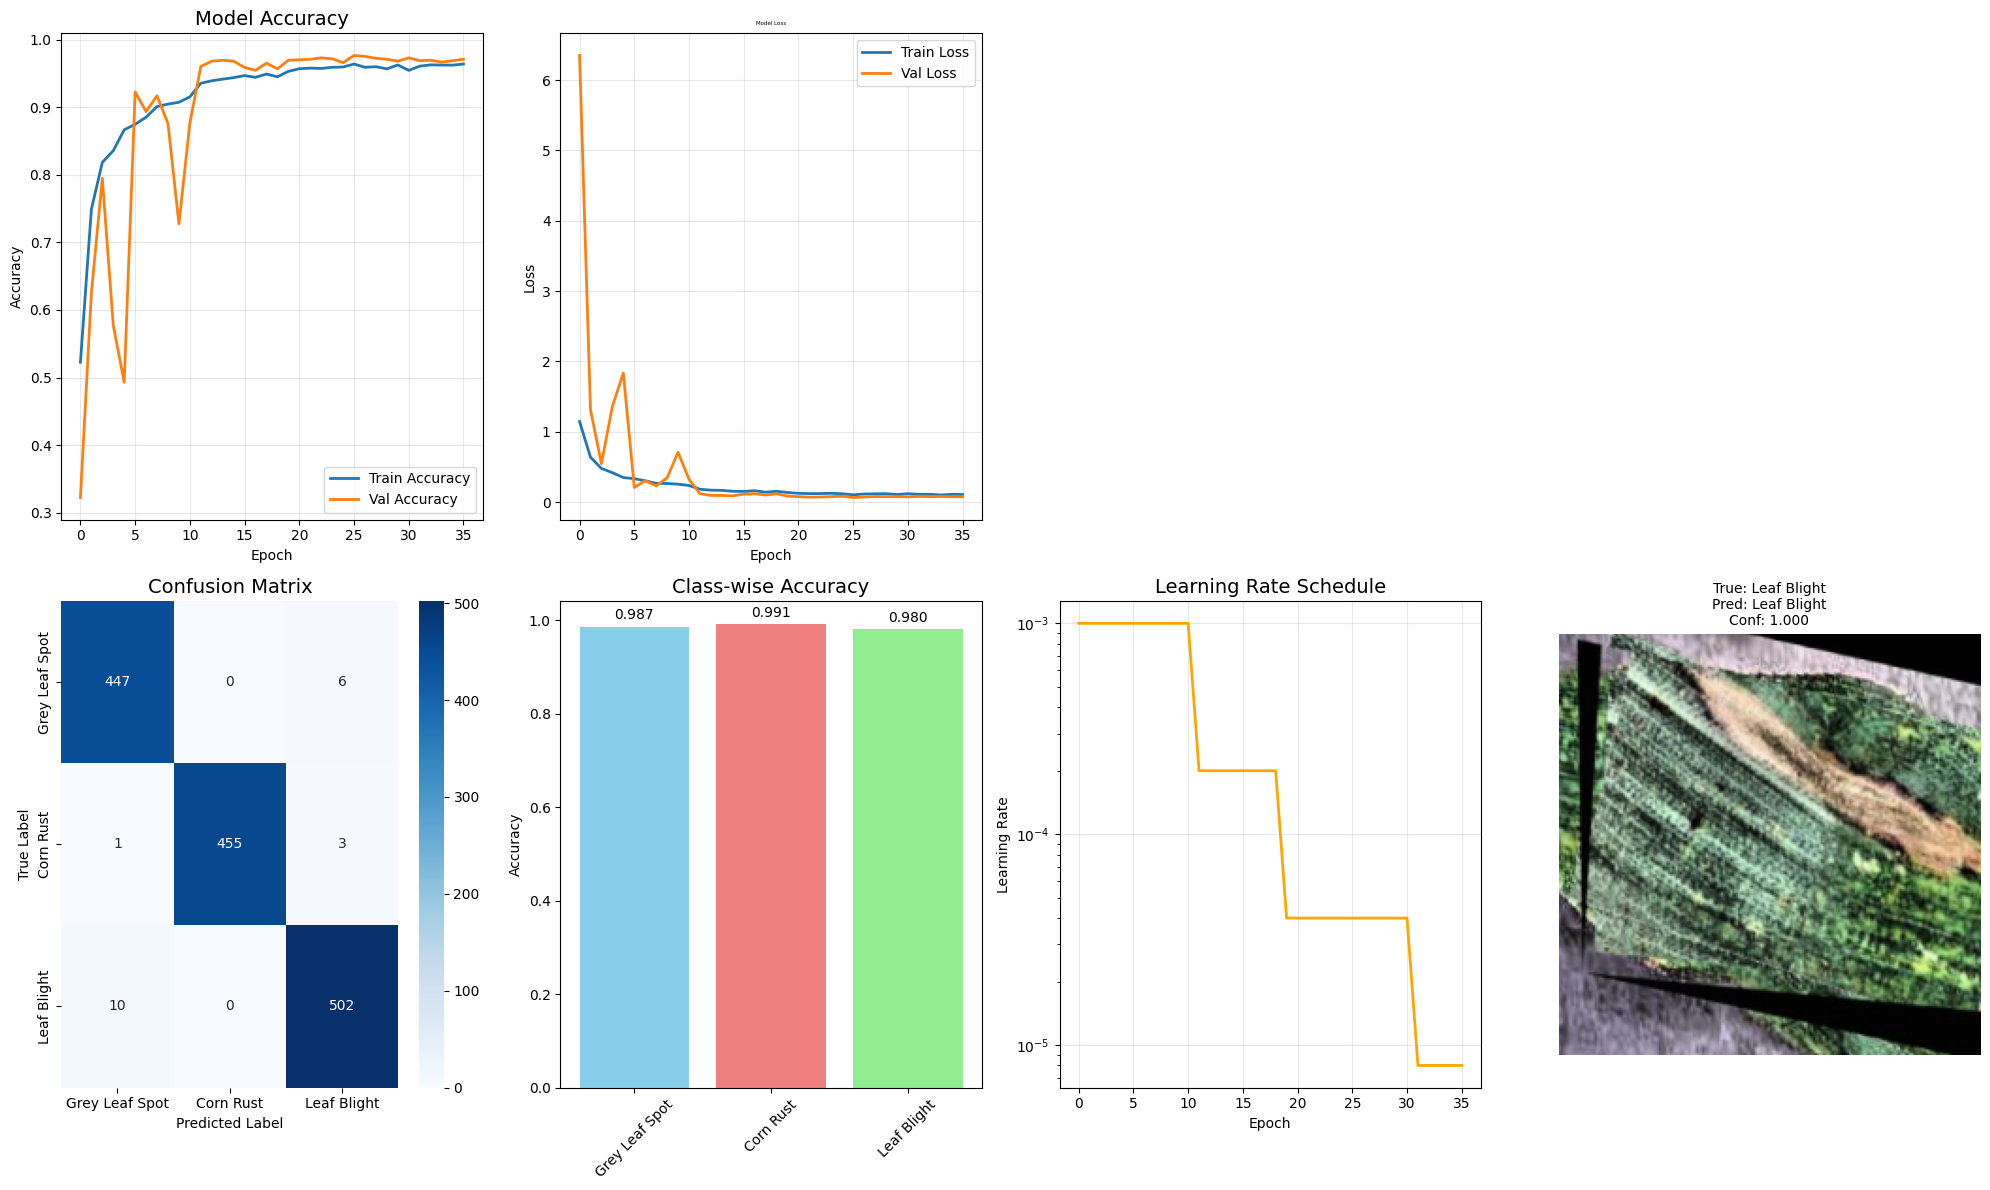


Custom CNN Performance Summary
Test Accuracy: 0.9860 (98.60%)


In [27]:
# Comprehensive visualization
plt.figure(figsize=(20, 12))

# Training history
plt.subplot(2, 4, 1)
plt.plot(history_custom.history['accuracy'], label='Train Accuracy', linewidth=2)
plt.plot(history_custom.history['val_accuracy'], label='Val Accuracy', linewidth=2)
plt.title('Model Accuracy', fontsize=14)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 4, 2)
plt.plot(history_custom.history['loss'], label='Train Loss', linewidth=2)
plt.plot(history_custom.history['val_loss'], label='Val Loss', linewidth=2)
plt.title('Model Loss', fontsize=4)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# plt.subplot(2, 4, 3)
# plt.plot(history_custom.history['precision'], label='Train Precision', linewidth=2)
# plt.plot(history_custom.history['val_precision'], label='Val Precision', linewidth=2)
# plt.title('Model Precision', fontsize=14)
# plt.xlabel('Epoch')
# plt.ylabel('Precision')
# plt.legned()
# plt.grid(True, alpha=0.3)

# plt.subplot(2, 4, 4)
# plt.plot(history_custom.history['recall'], label='Train Recall', linewidth=2)
# plt.plot(history_custom.history['val_recall'], label='Val Recall', linewidth=2)
# plt.title('Model Recall', fontsize=14)
# plt.xlabel('Epoch')
# plt.ylabel('Recall')
# plt.legend()
# plt.grid(True, alpha=0.3)

plt.subplot(2, 4, 5)
cm_custom = confusion_matrix(y_test, y_pred_classes_custom)
sns.heatmap(cm_custom, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix', fontsize=14)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# Class-wise accuracy
plt.subplot(2, 4, 6)
class_accuracy = cm_custom.diagonal() / cm_custom.sum(axis=1)
plt.bar(class_names, class_accuracy, color=['skyblue', 'lightcoral', 'lightgreen'])
plt.title('Class-wise Accuracy', fontsize=14)
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
for i, v in enumerate(class_accuracy):
    plt.text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')
    

# Learning rate schedule
plt.subplot(2, 4, 7)
if 'lr' in history_custom.history:
    plt.plot(history_custom.history['lr'], linewidth=2, color='orange')
    plt.title('Learning Rate Schedule', fontsize=14)
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.yscale('log')
    plt.grid(True, alpha=0.3)
    

# Sample predictions
plt.subplot(2, 4, 8)
sample_indices = np.random.choice(len(X_test), 1)
for i, idx in enumerate(sample_indices):
    sample_img = X_test[idx]
    true_label = class_names[y_test[idx]]
    pred_label = class_names[y_pred_classes_custom[idx]]
    confidence = np.max(y_pred_custom[idx])
    
    plt.imshow(sample_img)
    plt.title(f'True: {true_label}\nPred: {pred_label}\nConf: {confidence:.3f}', fontsize=10)
    plt.axis('off')
    
plt.tight_layout()
plt.show()


# Performance summary
print("\n" + "="*60)
print("Custom CNN Performance Summary")
print("="*60)
print(f"Test Accuracy: {test_results[1]:.4f} ({test_results[1]*100:.2f}%)")
# print(f"Test Precision: {test_results[2]:.4f}")
# print(f"Test Recall: {test_results[3]:.4f}")
# print(f"F1-Score: {2 * (test_results[2] * test_results[3]) / (test_results[2] + test_results[3]):.4f}")
print("="*60)

In [28]:
metrics = calculate_detailed_metrics(custom_model, test_generator_advanced, y_test)

📊 Detailed Metrics:
 Accuracy: 0.9860
 Precision: 0.9860
 Recall: 0.9860
 F1-Score: 0.9860


🔮 Testing prediction...
True label: Grey Leaf Spot
Predicted: Grey Leaf Spot (confidence: 0.9998)


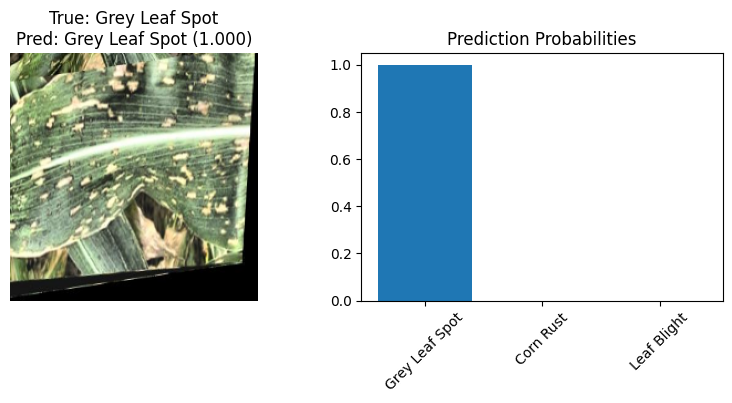

In [74]:
# 9. Create prediction function
def predict_disease(image_path, model, class_names):
    """
    Predict disease from image
    """
    # Load and preprocess image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    image = image.astype(np.float32) / 255.0
    image = np.expand_dims(image, axis=0)
    
    # Predict
    predictions = custom_model.predict(image, verbose=0)
    predicted_class = np.argmax(predictions[0])
    confidence = predictions[0][predicted_class]
    
    return class_names[predicted_class], confidence

# Test prediction
print("🔮 Testing prediction...")
# Ambil sample dari test set
sample_idx = np.random.randint(0, len(X_test))
sample_image = X_test[sample_idx]
true_label = class_names[y_test[sample_idx]]

# Predict
pred_probs = custom_model.predict(np.expand_dims(sample_image, axis=0), verbose=0)
pred_class = class_names[np.argmax(pred_probs[0])]
confidence = np.max(pred_probs[0])

print(f"True label: {true_label}")
print(f"Predicted: {pred_class} (confidence: {confidence:.4f})")

# Visualize
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(sample_image)
plt.title(f'True: {true_label}\nPred: {pred_class} ({confidence:.3f})')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.bar(class_names, pred_probs[0])
plt.title('Prediction Probabilities')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Convert Tensorflow Model to ONNX

In [82]:
import tf2onnx
import onnx 
import onnxruntime as ort
import tensorflow as tf 
import numpy as np 

In [75]:
# # Load train model
# model_path = './models/custom_corn_cnn_weights.h5'

# try:
#     loaded_model = tf.keras.models.load_model(model_path)
# except:
#     # If you only have weights, recreate the model first
#     loaded_model = create_custom_corn_cnn(num_classes=3)
#     loaded_model.load_weights(model_path)
#     loaded_model.compile(
#         optimizer='adam',
#         loss='sparse_categorical_crossentropy',
#         metrics=['accuracy']
#     )
#     print("Model recreated and weights loaded!")
    


In [77]:
# Define input signature
input_signature = [tf.TensorSpec(custom_model.input_shape, tf.float32)]

# Convert to ONNX
onnx_model, _ = tf2onnx.convert.from_keras(
    custom_model,
    input_signature=input_signature,
    opset=13 # ONNX opset version
)

# Save ONNX model
onnx_path = './models/corn_disease_model.onnx'
with open(onnx_path, 'wb') as f:
    f.write(onnx_model.SerializeToString())
    
print(f"Model converted to ONNX: {onnx_path}")

Model converted to ONNX: ./models/corn_disease_model.onnx


In [78]:
# Verify ONNX model
onnx_model_path = './models/corn_disease_model.onnx'

onnx_model = onnx.load(onnx_model_path)
onnx.checker.check_model(onnx_model)
print("ONNX model is valid")

print("ONNX model info:")
print(f" - IR version: {onnx_model.ir_version}")
print(f" - Producer: {onnx_model.producer_name}")
print(f"- Opset: {onnx_model.opset_import[0].version}")

# Print input/output info
for input_tensor in onnx_model.graph.input:
    print(f"- Input: {input_tensor.name}, Shape: {[d.dim_value for d in input_tensor.type.tensor_type.shape.dim]}")

for output_tensor in onnx_model.graph.output:
    print(f"- Output: {output_tensor.name}, Shape: {[d.dim_value for d in output_tensor.type.tensor_type.shape.dim]}")

ONNX model is valid
ONNX model info:
 - IR version: 7
 - Producer: tf2onnx
- Opset: 13
- Input: args_0, Shape: [0, 224, 224, 3]
- Output: dense_2, Shape: [0, 3]


In [83]:
# Create ONNX Runtime session
ort_session = ort.InferenceSession(onnx_model_path)

# Get input/output names
input_name = ort_session.get_inputs()[0].name
output_name = ort_session.get_outputs()[0].name

print(f"Input name: {input_name}")
print(f"Output name: {output_name}")

# Test with sample data
sample_input = np.random.random((1, 224, 224, 3)).astype(np.float32)

# Run inference
ort_outputs = ort_session.run([output_name], {input_name: sample_input})
onnx_prediction = ort_outputs[0]

print(f"ONNX prediction shape: {onnx_prediction.shape}")
print(f"ONNX prediction: {onnx_prediction}")

Input name: args_0
Output name: dense_2
ONNX prediction shape: (1, 3)
ONNX prediction: [[0.10974558 0.79146475 0.09878971]]


In [85]:
# Compare predictions between TensorFlow and ONNX
def compare_models(tf_model, onnx_session, test_input):
    """Compare TensorFlow and ONNX model predictions"""
    
    # TensorFlow prediction
    tf_pred = tf_model.predict(test_input, verbose=0)
    
    # ONNX prediction
    input_name = onnx_session.get_inputs()[0].name
    output_name = onnx_session.get_outputs()[0].name
    onnx_pred = onnx_session.run([output_name], {input_name: test_input})[0]
    
    # Calculate difference
    diff = np.abs(tf_pred - onnx_pred)
    max_diff = np.max(diff)
    mean_diff = np.mean(diff)
    
    print("📊 Model Comparison:")
    print(f"   TensorFlow prediction: {tf_pred[0]}")
    print(f"   ONNX prediction:      {onnx_pred[0]}")
    print(f"   Max difference:       {max_diff:.8f}")
    print(f"   Mean difference:      {mean_diff:.8f}")
    
    if max_diff < 1e-5:
        print("✅ Models are equivalent!")
    else:
        print("⚠️ Models have significant differences!")
    
    return tf_pred, onnx_pred

# Test with real sample
test_sample = X_test[0:1].astype(np.float32)  # Take first test sample
tf_pred, onnx_pred = compare_models(custom_model, ort_session, test_sample)

📊 Model Comparison:
   TensorFlow prediction: [9.9991262e-01 5.6415183e-06 8.1731509e-05]
   ONNX prediction:      [9.9991262e-01 5.6431654e-06 8.1728394e-05]
   Max difference:       0.00000000
   Mean difference:      0.00000000
✅ Models are equivalent!


In [89]:
# Create prediction function for ONNX model
def predict_with_onnx(image_path, onnx_session, class_names):
    """
    Predict disease using ONNX model
    """
    # Load and preprocess image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    image = image.astype(np.float32) / 255.0
    image = np.expand_dims(image, axis=0)
    
    # Get input/output names
    input_name = onnx_session.get_inputs()[0].name
    output_name = onnx_session.get_outputs()[0].name
    
    # Run inference
    predictions = onnx_session.run([output_name], {input_name: image})[0]
    predicted_class = np.argmax(predictions[0])
    confidence = predictions[0][predicted_class]
    
    return class_names[predicted_class], confidence, predictions[0]

# Test ONNX prediction function
print("🔮 Testing ONNX prediction...")
# You would use this with an actual image file:
pred_class, confidence, probs = predict_with_onnx('./data_rebalanced/test/0a01cc10-3892-4311-9c48-0ac6ab3c7c43___RS_GLSp-9352_90deg_JPG_jpg.rf.42574608e8d8c023ed5f1852ae860591.jpg', ort_session, class_names)
print(f"Predicted: {pred_class} (confidence: {confidence:.4f})")

🔮 Testing ONNX prediction...
Predicted: Grey Leaf Spot (confidence: 0.9899)
